In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import string
import re
import wordninja   
import emoji
from nltk.corpus import stopwords 
import nltk
import contractions
from collections import  Counter
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models
from wordcloud import WordCloud, STOPWORDS
import spacy

In [2]:
df = pd.read_csv("../../datasets/NYT_Russia_Ukraine.csv")
df

,published,headlines,articles
0,2022/06/23,"For a Kyiv Techno Collective, ‘Now Everything ...",When Slava Lepsheiev founded the Ukrainian tec...
1,2022/06/21,"After a Pivotal Period in Ukraine, U.S. Offici...",Several military analysts say Russia is at pea...
2,2022/06/13,"The Corpse of a Russian Soldier, and the Cold ...",The Russians have abandoned the bodies of many...
3,2022/06/11,Biden Races to Expand Coalition Against Russia...,"A month later, Mr. Ramaphosa lamented the impa..."
4,2022/06/13,"As China Rattles Sabers, Taiwan Asks: Are We R...",Underlying Taiwan’s defense dilemma is a quest...
...,...,...,...
214,2022/07/15,"In a Flash of Fire and Shrapnel, a Smiling 4-Y...",Whether through callousness in targeting or si...
215,2022/07/15,Energy Was the Only Bright Spot in the Stock M...,The energy industry has become the stock marke...
216,2022/07/15,The many parties involved complicate war crime...,A Russian missile strike on a city in central ...
217,2022/07/03,An American’s Murky Path From Russian Propagan...,"Konstantin Malofeev, an influential oligarch i..."


# Preprocess

In [3]:
df["headlines"] = df["headlines"].apply(lambda x: str(x).replace("\n", " ")
                                                              .replace("\t", " ")
                                                              .replace("\xa0", " ")
                                                              .replace("\r", " ")
                                                              .replace("[", "")
                                                              .replace("]", "")
                                                              .replace("\ufeff", "")
                                                              .replace("\u200b", "")
                                                              .replace("©", "")
                                                              .replace("|", "")
                                                              .replace("#", "")
                                                              .lower()
                                                              .strip())

In [4]:
df['headlines'] = df['headlines'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

df['headlines'] = df['headlines'].apply(lambda x: re.sub('[0-9]', '', x))

df["headlines"] = df["headlines"].apply(lambda x: re.sub(' +', ' ', x))

In [5]:
for i in range(len(df)):
    try:
        df.headlines[i] = emoji.replace_emoji(df.headlines[i], ' ')
    except:
        pass

In [6]:
for i in df.index:
    df.headlines[i] = ' '.join(wordninja.split(df.headlines[i]))  

In [7]:
stop_words = set(stopwords.words('english'))
stop_words.update(['https', 'http', 'com', 'www', 'https://', 
            'http://', 'com/', 'www/', 'width', 'device', 
            'initial', 'scale', 'height', 'px', 'px/', 'px',
            'ie', 'edge', 'chrome', 'firefox', 'safari', 'opera',
            'wi', 'x', 'com', 'website', 'builder', 'telephone', 'skype',
            'toolbar', 'button', 'link', 'image', 'icon', 'icon/',
            'parser', 'compatible', 'fcb', 'ea', 'cf',
            'drop', 'menu', 'de', 'ee', 'ab', 'bb', 'df', 'ff', 'fb', 'eb',
            'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
            'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
            'html', 'css', 'js', 'json', 'xml', 'json/', 'xml/', 'js/', 'json/',
            'char', 'set', 'utf', 'utf-', 'utf8', 'utf8/', 'utf8', 'utf8/',
            'text', 'minimum', 'maximum', 'length', 'required', 'optional',
            'index', 'nofollow', 'user', 'scalable', 'responsive', 'mobile'])
df['headlines'] = df['headlines'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [8]:
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
df['headlines'] = df['headlines'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hasan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
for i in df.index:
    try:
        df.headlines[i] = contractions.fix(df.headlines[i])
    except:
        pass

In [10]:
words = set(nltk.corpus.words.words())
for i in df.index:
    df.headlines[i] = " ".join(w for w in nltk.wordpunct_tokenize(df.headlines[i]) \
         if w.lower() in words or not w.isalpha())

In [11]:
df.headlines

0                         collective everything politics
1           pivotal period you official predict war path
2                    corpse soldier cold human urge look
3           race expand coalition russia meet resistance
4                           china rattle saber ready war
                             ...                        
214            flash fire shrapnel smiling year old life
215                energy bright spot stock market gloom
216    many party involved complicate war crime inves...
217                              murky path propagandist
218      gap arm supply point country divergent strategy
Name: headlines, Length: 219, dtype: object

# Top Words

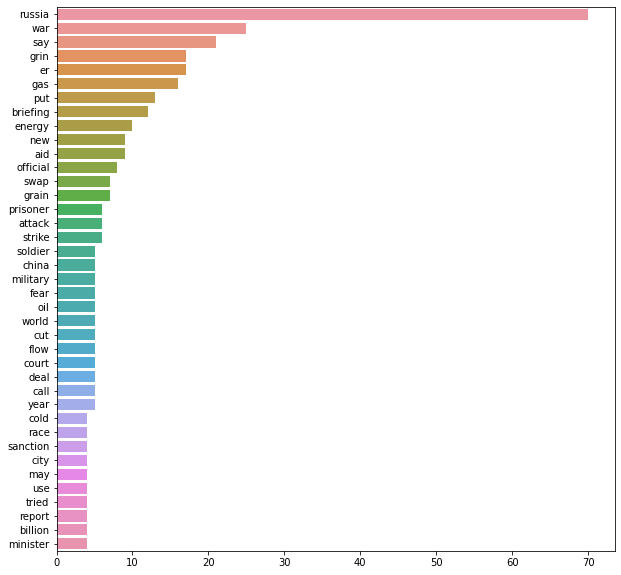

In [12]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

plot_top_non_stopwords_barchart(df['headlines'])

# Top ngrams

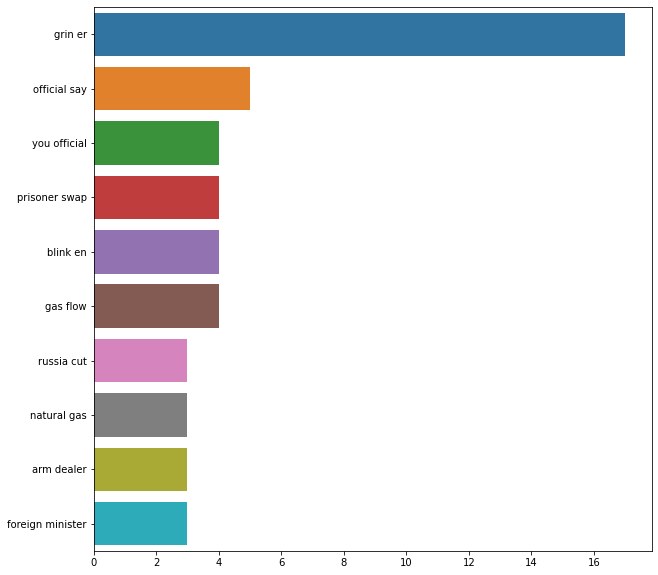

In [13]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(df['headlines'],2)

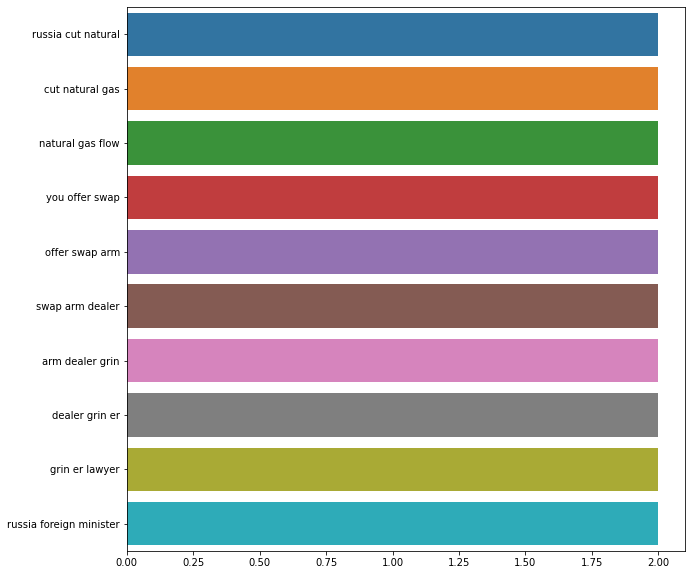

In [14]:
plot_top_ngrams_barchart(df['headlines'], 3)

# Topic modeling exploration with pyLDAvis

In [15]:
def get_lda_objects(text):   
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
    return vis


lda_model, bow_corpus, dic = get_lda_objects(df['headlines'])

lda_model.show_topics()

plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.148782  0.029779       1        1  14.052112
8     -0.043637  0.063238       2        1  11.053650
5      0.055131  0.011475       3        1  10.808490
9     -0.024611  0.036931       4        1  10.673227
0      0.005520  0.105451       5        1  10.085129
1      0.094452 -0.075325       6        1   9.895004
6     -0.097878  0.028913       7        1   9.489747
2     -0.035066 -0.110379       8        1   9.159072
3     -0.043487 -0.078650       9        1   8.679560
7     -0.059205 -0.011432      10        1   6.104011, topic_info=          Term       Freq      Total Category  logprob  loglift
445   briefing   7.000000   7.000000  Default  30.0000  30.0000
182      grain   5.000000   5.000000  Default  29.0000  29.0000
60         aid   6.000000   6.000000  Default  28.0000  28.0000
130        gas  10.000000  10.000000  Default  27.0000  27.0000
105       grin  12.000000  12.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
65    diplomat   0.613673   1.826258  Topic10  -4.7738   1.7057
55      threat   0.613672   1.859186  Topic10  -4.7738   1.6878
51   highlight   0.613672   1.852192  Topic10  -4.7738   1.6916
34     company   0.613672   2.508603  Topic10  -4.7738   1.3882
518       fire   0.613671   3.091683  Topic10  -4.7738   1.1792

[543 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
302       5  0.779637  absence
210       4  0.527932    abuse
210       9  0.527932    abuse
211       9  0.803280    abyss
417       3  0.772612   access
...     ...       ...      ...
315       1  0.254093     year
315       6  0.254093     year
315       8  0.254093     year
506       7  0.524236    young
162       5  0.779637     zing

[714 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 6, 10, 1, 2, 7, 3, 4, 8])

# Word Cloud

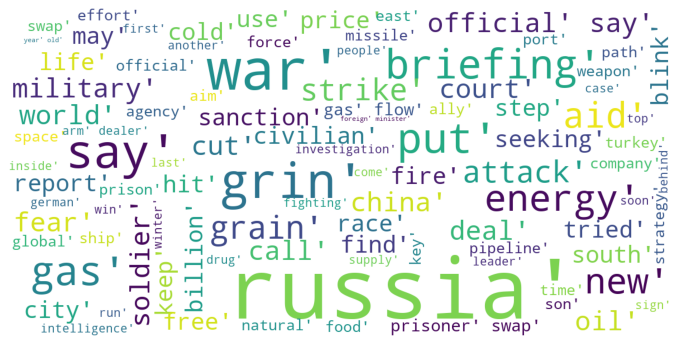

In [16]:
def plot_wordcloud(text):
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=120,
        max_font_size=50, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()
    
plot_wordcloud(df["headlines"])

# Named entity recognition

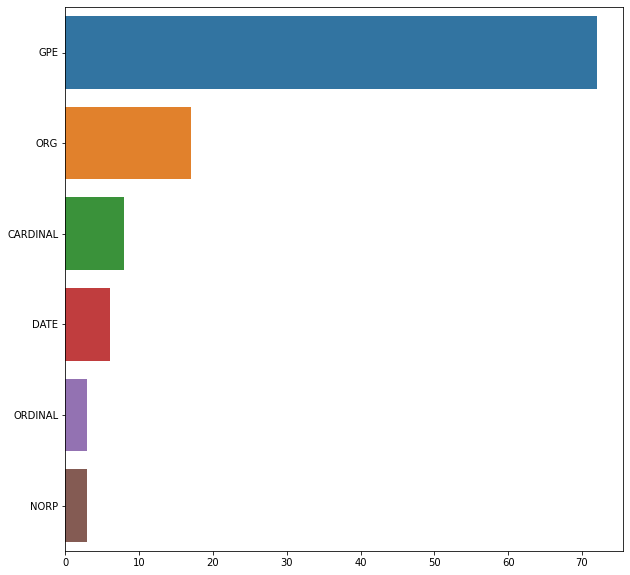

In [17]:
def plot_named_entity_barchart(text):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]
    
    ent=text.apply(lambda x : _get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()
    
    x,y=map(list,zip(*count))
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)
    
plot_named_entity_barchart(df["headlines"])

# Most common Country names

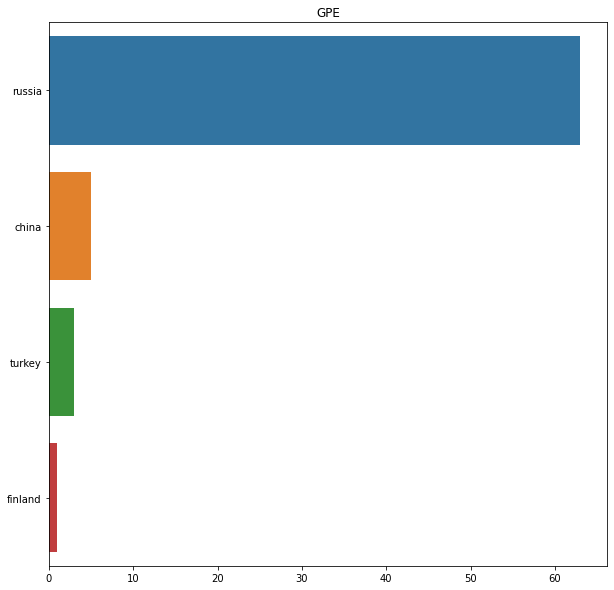

In [18]:
def plot_most_common_named_entity_barchart(text, entity="PERSON"):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text,ent):
        doc=nlp(text)
        return [X.text for X in doc.ents if X.label_ == ent]

    entity_filtered=text.apply(lambda x: _get_ner(x,entity))
    entity_filtered=[i for x in entity_filtered for i in x]
    
    counter=Counter(entity_filtered)
    x,y=map(list,zip(*counter.most_common(10)))
    plt.figure(figsize=(10,10))
    sns.barplot(y,x).set_title(entity)
    
plot_most_common_named_entity_barchart(df['headlines'], entity="GPE")